
<div style="text-align: center;">
<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Neural Networks on Japanese MNIST dataset
<br>
</div>



</div>
<br>
<hr>
<br>
<pre style="text-align: right;">
AGUSTIN PABLO FERRARI
24704114
MARCH 2024
DEEP LEARNING
UNIVERSITY OF TECHNOLOGY SYDNEY
<br>
</pre>

<hr>

<br>

<img src="https://unglobalcompact.org.au/wp-content/uploads/2020/04/UTS-Logo-Syd.jpg" alt="Image Alt Text" width="200" height="100">

<br>
<br>

</div>



<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Notebook's objective
<br>
</div>



The Japanese MNIST dataset. It is composed of 70000 images of handwritten Hiragana characters. The target variables has 10 different classes.

Each image is of dimension 28 by 28. But it will flatten to form a dataset composed of vectors of dimension (784, 1). The training process will be similar as for a structured dataset, therefore no Convolutional Neural Network will be used.

The objective: Reaching at least 80% of accuracy without overfitting the model.

<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Importing libraries
<br>
</div>

In [1]:

# Import general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# [3.1] Import the required modules from PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets import MNIST
from keras.utils import to_categorical


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Loading the dataset
<br>
</div>

In [3]:

# [3.2] 
# Create 2 variables called img_height and img_width that will both take the value 28
img_height = 28
img_width = 28


In [4]:

# [3.3]
# Create a function that loads a .npz file using numpy and return the content of the arr_0 key
def load(f):
    return np.load(f)['arr_0']


In [5]:

# [3.4]
# Load the 4 files saved on your *Files* into their respective variables: x_train, y_train, x_test and y_test
x_train = load('C:\\Users\\ferra\\OneDrive\\Escritorio\\Master Of Data Science\\Deep Learning\\Assignment 1\\Assignment 1 - Part B\\KMINST Dataset\\kmnist-train-imgs.npz')
y_train = load('C:\\Users\\ferra\\OneDrive\\Escritorio\\Master Of Data Science\\Deep Learning\\Assignment 1\\Assignment 1 - Part B\\KMINST Dataset\\kmnist-train-labels.npz')
x_test = load('C:\\Users\\ferra\\OneDrive\\Escritorio\\Master Of Data Science\\Deep Learning\\Assignment 1\\Assignment 1 - Part B\\KMINST Dataset\\kmnist-test-imgs.npz')
y_test = load('C:\\Users\\ferra\\OneDrive\\Escritorio\\Master Of Data Science\\Deep Learning\\Assignment 1\\Assignment 1 - Part B\\KMINST Dataset\\kmnist-test-labels.npz')


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Transforming the data
<br>
</div>

In [6]:

# Reshape the images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalize the pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Benchmark
<br>
</div>

Calculating a benchmark by predicting with a multiple logistic regression model.

The results of the Neural Network should improve this result

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression model
model = LogisticRegression(max_iter=5000)

# Flatten the images
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

# Train the model
model.fit(x_train_flattened, y_train) 

# Predict on the test set
y_pred = model.predict(x_test_flattened)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy benchmarked as:", accuracy)


Test accuracy benchmarked as: 0.694


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Transforming the data 2
<br>
</div>

In [8]:
# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Create TensorDataset and DataLoader for training and testing sets
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

# Batch size
batch_size = 256

# DataLoader for training and test set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Training Neural Network function
<br>
</div>

In [9]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, train_dataloader, test_dataloader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store predictions and targets for training
    train_preds = []
    train_targets = []

    # Perform predictions on the training data
    with torch.no_grad():
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

    # Convert lists to numpy arrays
    train_preds = np.array(train_preds)
    train_targets = np.array(train_targets)

    # Convert train_targets to a format compatible with confusion matrix
    train_targets_argmax = np.argmax(train_targets, axis=1)

    # Train Confusion Matrix
    plot_confusion_matrix(train_targets_argmax, train_preds, title='Train Confusion Matrix')

    # Initialize lists to store predictions and targets for testing
    test_preds = []
    test_targets = []

    # Perform predictions on the testing data
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    # Convert lists to numpy arrays
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)

    # Convert test_targets to a format compatible with confusion matrix
    test_targets_argmax = np.argmax(test_targets, axis=1)

    # Test Confusion Matrix
    plot_confusion_matrix(test_targets_argmax, test_preds, title='Test Confusion Matrix')

    print("-----------------Accuracy scores for {} are: -----------------\n".format(model.name))
    
    # Calculate accuracy score for the training set
    train_accuracy = accuracy_score(train_targets_argmax, train_preds)
    print(f"Training Accuracy: {train_accuracy}")

    # Calculate accuracy score for the testing set
    test_accuracy = accuracy_score(test_targets_argmax, test_preds)
    print(f"Testing Accuracy: {test_accuracy}")


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_loss = []
    train_accuracy = []
    test_accuracy = []
    total_train_loss = []  # Store the training loss for each epoch
    total_test_loss = []   # Store the testing loss for each epoch
    train_preds = []       # Store the training predictions
    train_targets = []     # Store the training targets
    test_preds = []        # Store the test predictions
    test_targets = []      # Store the test targets

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_train_preds = []

        model.train()
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_train_preds.extend(predicted.cpu().numpy())

        epoch_loss /= len(train_dataloader)
        total_train_loss.append(epoch_loss)  # Append the training loss for this epoch to the list

        train_acc = accuracy_score(np.argmax(y_train, axis=1)[:len(epoch_train_preds)], np.array(epoch_train_preds))
        train_accuracy.append(train_acc)

        train_preds.extend(epoch_train_preds)
        train_targets.extend(targets.cpu().numpy())

        model.eval()
        with torch.no_grad():
            epoch_test_preds = []
            epoch_test_loss = 0.0
            
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(targets, dim=1))
                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                epoch_test_preds.extend(predicted.cpu().numpy())
                test_targets.extend(targets.cpu().numpy())
            
            epoch_test_loss /= len(test_dataloader)
            total_test_loss.append(epoch_test_loss)  # Append the testing loss for this epoch to the list

            test_acc = accuracy_score(np.argmax(y_test, axis=1), np.array(epoch_test_preds))
            test_accuracy.append(test_acc)
            test_preds.extend(epoch_test_preds)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")

    # Plot train and test loss
    plt.figure()
    plt.plot(range(1, epochs + 1), total_train_loss, label='Train Loss', color='orange')
    plt.plot(range(1, epochs + 1), total_test_loss, label='Test Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss per Epoch (v4)')
    plt.legend()
    plt.show()

    return model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device


def plot_confusion_matrix(targets, preds, title='Confusion Matrix', labels=None):
    conf_matrix = confusion_matrix(targets, preds)
    if labels is None:
        labels = np.unique(targets)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## First NN, First experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
1) Simple NN with only one hidden layers - ReLu - Adam - 0.005 lr
<br> 
<br>


In [11]:

# Create the empty summary dataframe where all results are going to be saved
results_df = pd.DataFrame(columns=['Model Name', 'Model', 'Total Train Loss', 'Total Test Loss', 'Train Accuracy', 'Test Accuracy'])


Epoch [1/100], Train Loss: 0.3881439335802768, Test Loss: 0.5014483012259007
Epoch [2/100], Train Loss: 0.16400088854926698, Test Loss: 0.3958814240992069
Epoch [3/100], Train Loss: 0.10769228515155772, Test Loss: 0.41232956759631634
Epoch [4/100], Train Loss: 0.07467523336093476, Test Loss: 0.38400589153170583
Epoch [5/100], Train Loss: 0.05220321183826061, Test Loss: 0.44729432500898836
Epoch [6/100], Train Loss: 0.04138302235923549, Test Loss: 0.43120125159621236
Epoch [7/100], Train Loss: 0.034332468470637784, Test Loss: 0.45274021830409766
Epoch [8/100], Train Loss: 0.024384231310575568, Test Loss: 0.47915850058197973
Epoch [9/100], Train Loss: 0.024990161263601894, Test Loss: 0.5365320913493633
Epoch [10/100], Train Loss: 0.027307804056661243, Test Loss: 0.6231578789651394
Epoch [11/100], Train Loss: 0.023818185482610096, Test Loss: 0.6709643870592117
Epoch [12/100], Train Loss: 0.016776176170505426, Test Loss: 0.6200557064265013
Epoch [13/100], Train Loss: 0.019684508054497393, 

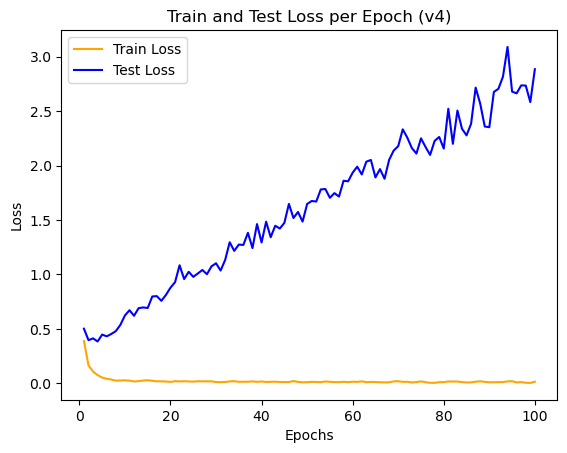

-----------------Experiment1 MODEL-----------------

NeuralNetwork1(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
) 

-----------------MODEL EVALUATION-----------------



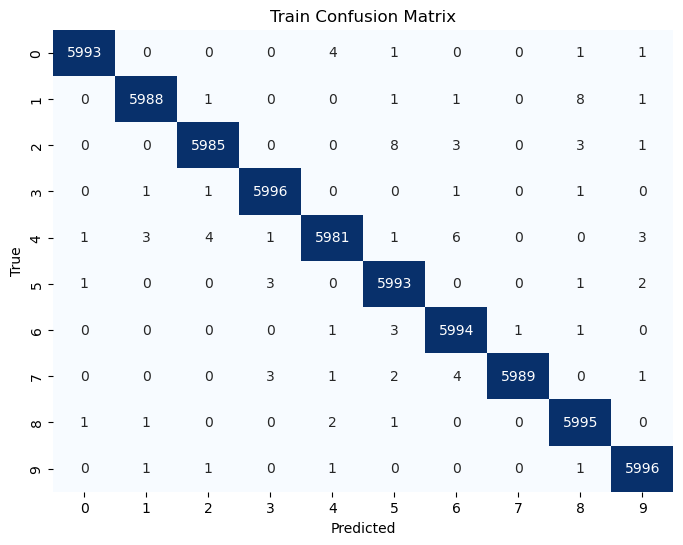

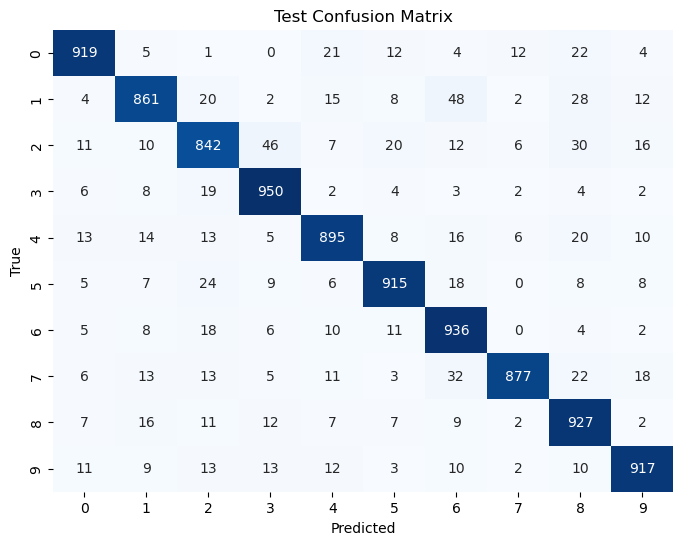

-----------------Accuracy scores for Experiment1 are: -----------------

Training Accuracy: 0.9985
Testing Accuracy: 0.9039


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\3568770474.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [12]:

#1) Simple NN with only two hidden layers - ReLu - Adam

# ⚠️ Define the Neural Network architecture ⚠️
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # hidden layer
        self.fc2 = nn.Linear(256, 10)   # Output layer with 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.fc2(x)  # Output layer
        return x

# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork1()
model.name = "Experiment1"
epochs = 100
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## First NN, Second experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
1) Simple NN with only one hidden layers - ReLu - Adam - 0.0005 lr
<br> 
<br>


Epoch [1/100], Train Loss: 0.7863274688416338, Test Loss: 0.8328612968325615
Epoch [2/100], Train Loss: 0.42372651784978016, Test Loss: 0.6934965267777443
Epoch [3/100], Train Loss: 0.32758307070174114, Test Loss: 0.6068722948431968
Epoch [4/100], Train Loss: 0.2701409945462612, Test Loss: 0.5547984309494496
Epoch [5/100], Train Loss: 0.22908569089275727, Test Loss: 0.5109889276325703
Epoch [6/100], Train Loss: 0.1959290361467828, Test Loss: 0.4714030236005783
Epoch [7/100], Train Loss: 0.169829464529423, Test Loss: 0.4463682919740677
Epoch [8/100], Train Loss: 0.14950112814598895, Test Loss: 0.4239695992320776
Epoch [9/100], Train Loss: 0.1312353083744962, Test Loss: 0.4149693697690964
Epoch [10/100], Train Loss: 0.11642327993474108, Test Loss: 0.3926114320755005
Epoch [11/100], Train Loss: 0.10346018450057252, Test Loss: 0.38750804401934147
Epoch [12/100], Train Loss: 0.09153947460841626, Test Loss: 0.3802232123911381
Epoch [13/100], Train Loss: 0.08232632661436466, Test Loss: 0.3699

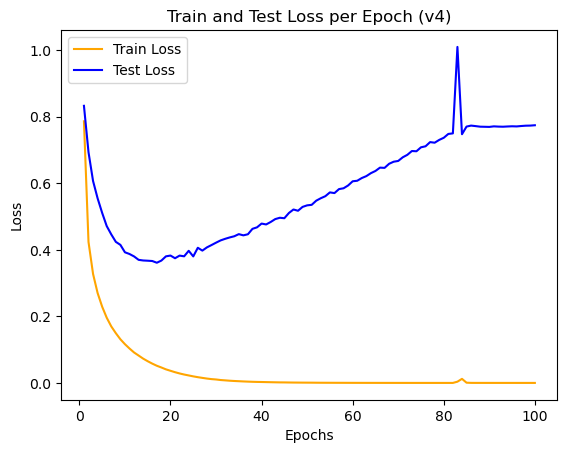

-----------------Experiment1 MODEL-----------------

NeuralNetwork1(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
) 

-----------------MODEL EVALUATION-----------------



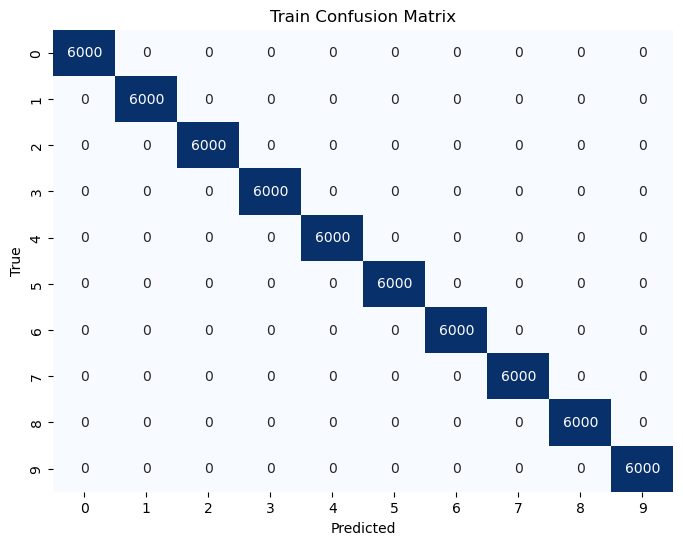

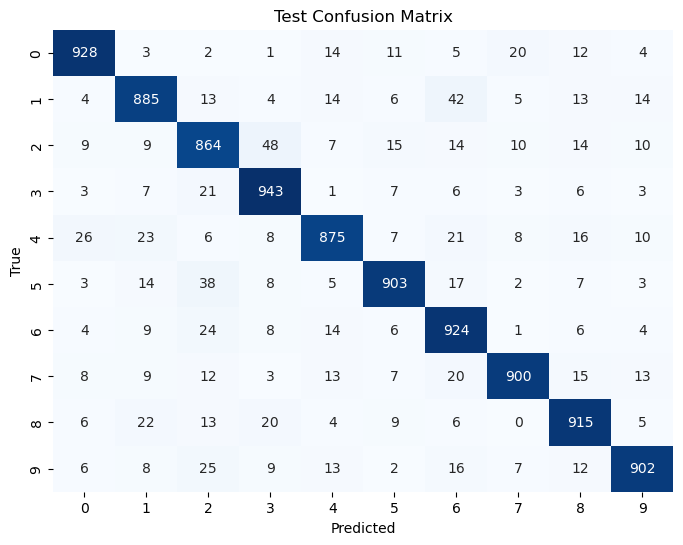

-----------------Accuracy scores for Experiment1 are: -----------------

Training Accuracy: 1.0
Testing Accuracy: 0.9039


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\1041368766.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [13]:

#1) Simple NN with only two hidden layers - ReLu - Adam

# ⚠️ Define the Neural Network architecture ⚠️
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # hidden layer
        self.fc2 = nn.Linear(256, 10)   # Output layer with 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.fc2(x)  # Output layer
        return x

# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork1()
model.name = "Experiment1"
epochs = 100
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## First NN, Third experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
1) Simple NN with only one hidden layers - ReLu - Adam - 0.00005 lr
<br> 
<br>


Epoch [1/100], Train Loss: 1.714695479514751, Test Loss: 1.5644514501094817
Epoch [2/100], Train Loss: 1.0134731036551454, Test Loss: 1.2607351690530777
Epoch [3/100], Train Loss: 0.7850551389633341, Test Loss: 1.120454953610897
Epoch [4/100], Train Loss: 0.6789873133314417, Test Loss: 1.0343129009008407
Epoch [5/100], Train Loss: 0.6149336036215437, Test Loss: 0.9781576514244079
Epoch [6/100], Train Loss: 0.5708912818989855, Test Loss: 0.9423401191830635
Epoch [7/100], Train Loss: 0.5371013747884872, Test Loss: 0.896979846060276
Epoch [8/100], Train Loss: 0.5091867384758402, Test Loss: 0.8599548056721688
Epoch [9/100], Train Loss: 0.4858818061808322, Test Loss: 0.8371242091059685
Epoch [10/100], Train Loss: 0.465369451680082, Test Loss: 0.8160722240805626
Epoch [11/100], Train Loss: 0.44707690921235593, Test Loss: 0.7903664737939835
Epoch [12/100], Train Loss: 0.4301603099133106, Test Loss: 0.7734964072704316
Epoch [13/100], Train Loss: 0.4148654204733828, Test Loss: 0.755706104636192

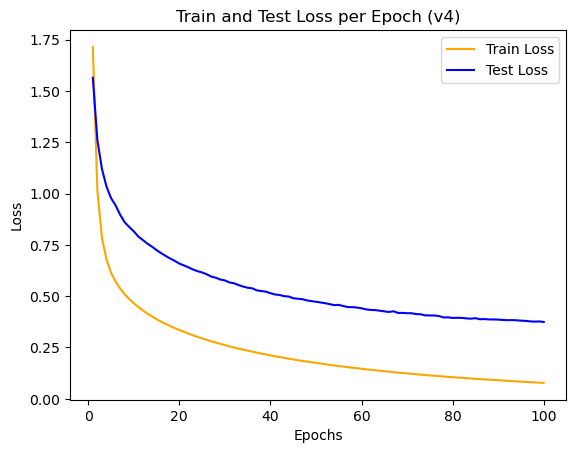

-----------------Experiment1 MODEL-----------------

NeuralNetwork1(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
) 

-----------------MODEL EVALUATION-----------------



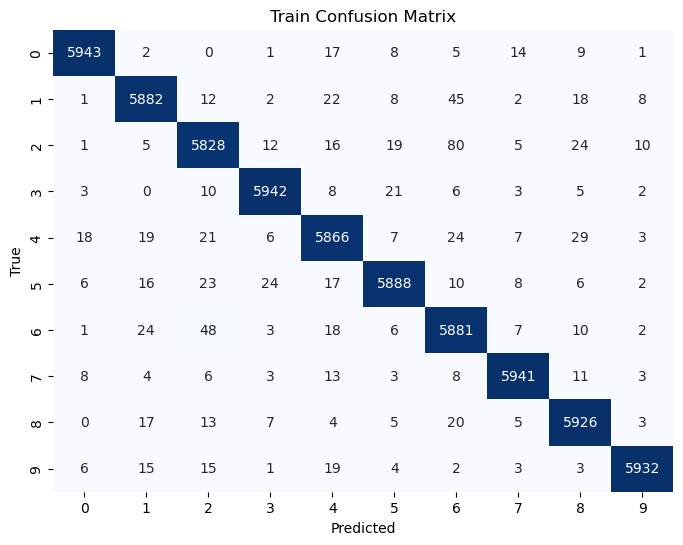

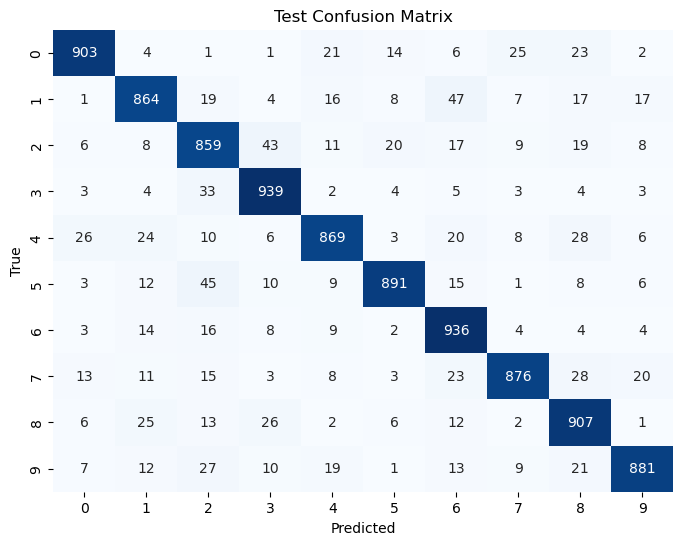

-----------------Accuracy scores for Experiment1 are: -----------------

Training Accuracy: 0.9838166666666667
Testing Accuracy: 0.8925


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\3955297624.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [14]:

#1) Simple NN with only two hidden layers - ReLu - Adam

# ⚠️ Define the Neural Network architecture ⚠️
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # hidden layer
        self.fc2 = nn.Linear(256, 10)   # Output layer with 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.fc2(x)  # Output layer
        return x

# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork1()
model.name = "Experiment1"
epochs = 100
learning_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Second NN architecture, fourth experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
4) 2 hidden layers and a dropout - ReLu - Adam - 0.00005 lr
<br> 
<br>


Epoch [1/100], Train Loss: 1.8710843273933897, Test Loss: 1.6572540372610092
Epoch [2/100], Train Loss: 1.057244062677343, Test Loss: 1.282134199142456
Epoch [3/100], Train Loss: 0.7706403493881225, Test Loss: 1.120645748078823
Epoch [4/100], Train Loss: 0.6550265568367979, Test Loss: 1.0150061830878259
Epoch [5/100], Train Loss: 0.5916042590394933, Test Loss: 0.9552018359303475
Epoch [6/100], Train Loss: 0.5494216322898865, Test Loss: 0.9147240832448006
Epoch [7/100], Train Loss: 0.5176238436648186, Test Loss: 0.8783188223838806
Epoch [8/100], Train Loss: 0.49132346130431964, Test Loss: 0.8445037394762039
Epoch [9/100], Train Loss: 0.46888194807032324, Test Loss: 0.8200732454657554
Epoch [10/100], Train Loss: 0.44926383203648507, Test Loss: 0.7932067066431046
Epoch [11/100], Train Loss: 0.43144645589463254, Test Loss: 0.7768028520047665
Epoch [12/100], Train Loss: 0.4159302049494804, Test Loss: 0.7565231040120125
Epoch [13/100], Train Loss: 0.401911498764728, Test Loss: 0.746139807999

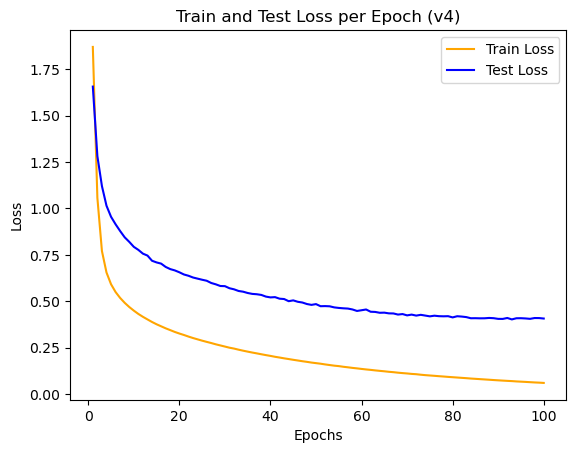

-----------------Experiment4-0.00005lr MODEL-----------------

NeuralNetwork2(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
) 

-----------------MODEL EVALUATION-----------------



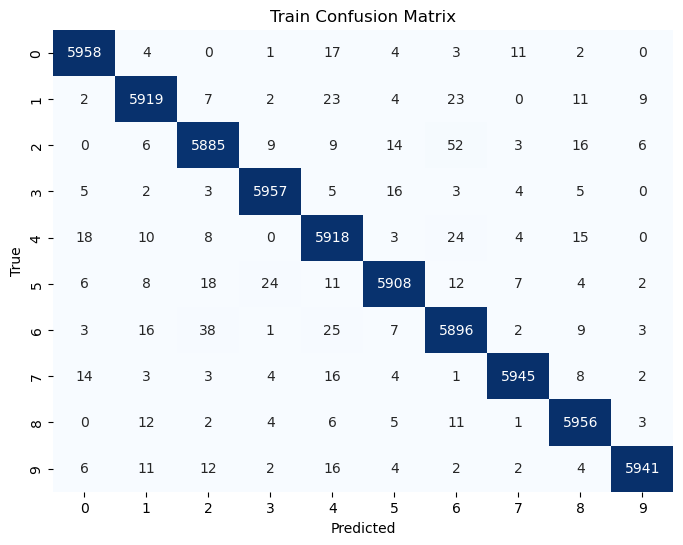

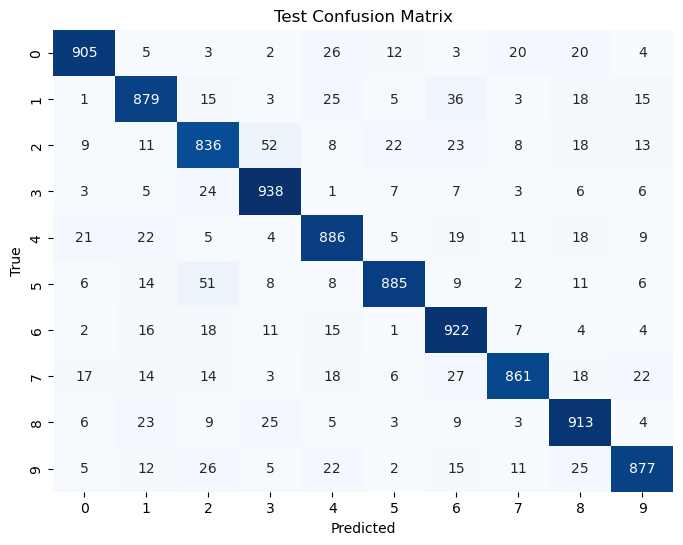

-----------------Accuracy scores for Experiment4-0.00005lr are: -----------------

Training Accuracy: 0.98805
Testing Accuracy: 0.8902


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\4224896890.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [15]:

# Train the model with the best epoch

#4) 2 hidden layers and a dropout - ReLu - Adam - 0.00005 lr

# Define the Neural Network architecture
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()  # ⚠️ change name here as well ⚠️
        self.fc1 = nn.Linear(784, 256)  # hidden layer 1
        self.dropout = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.fc2 = nn.Linear(256, 64)   # hidden layer 2
        self.fc3 = nn.Linear(64, 10)    # Output layer with 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.fc3(x)  # Output layer
        return x

# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork2()
model.name = "Experiment4-0.00005lr"
epochs = 100
learning_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Third NN architecture, fifth experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
5) 2 hidden layers and 2 dropout - ReLu - Adam - 0.00005 lr - Increase in nodes
<br> 
<br>


Epoch [1/100], Train Loss: 1.6070200783141115, Test Loss: 1.3413649410009385
Epoch [2/100], Train Loss: 0.8538615591982578, Test Loss: 1.0589444011449813
Epoch [3/100], Train Loss: 0.6806903699611095, Test Loss: 0.9379921555519104
Epoch [4/100], Train Loss: 0.5968898497997446, Test Loss: 0.8639941066503525
Epoch [5/100], Train Loss: 0.5356132674724497, Test Loss: 0.7938172817230225
Epoch [6/100], Train Loss: 0.48828724559317244, Test Loss: 0.7501911818981171
Epoch [7/100], Train Loss: 0.45193386369563165, Test Loss: 0.7090449243783951
Epoch [8/100], Train Loss: 0.4197973005315091, Test Loss: 0.6752580024302006
Epoch [9/100], Train Loss: 0.3941826124774649, Test Loss: 0.6473279654979706
Epoch [10/100], Train Loss: 0.3706573084313819, Test Loss: 0.6224546484649182
Epoch [11/100], Train Loss: 0.3516724750082544, Test Loss: 0.5987163931131363
Epoch [12/100], Train Loss: 0.33460494413020764, Test Loss: 0.5825201995670796
Epoch [13/100], Train Loss: 0.31818915916250107, Test Loss: 0.56179881

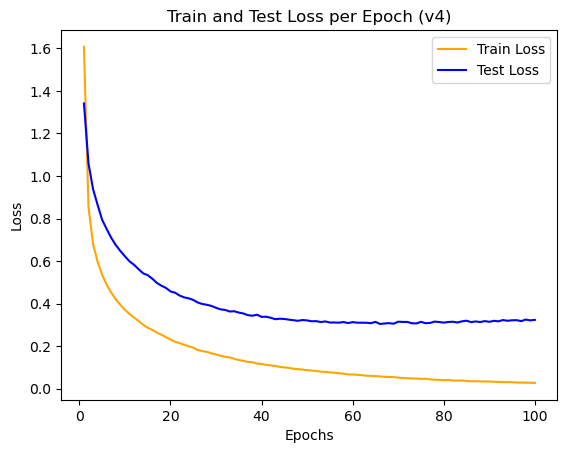

-----------------Experiment5-Regularising-0.00005lr - Increase in nodes MODEL-----------------

NeuralNetwork3(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
) 

-----------------MODEL EVALUATION-----------------



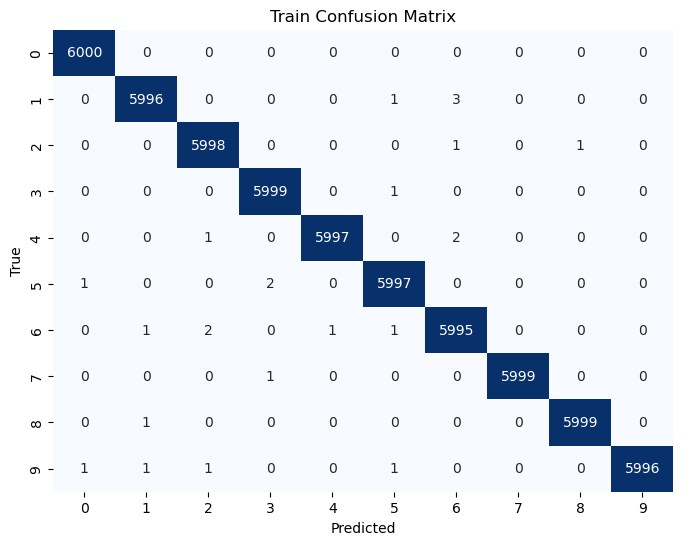

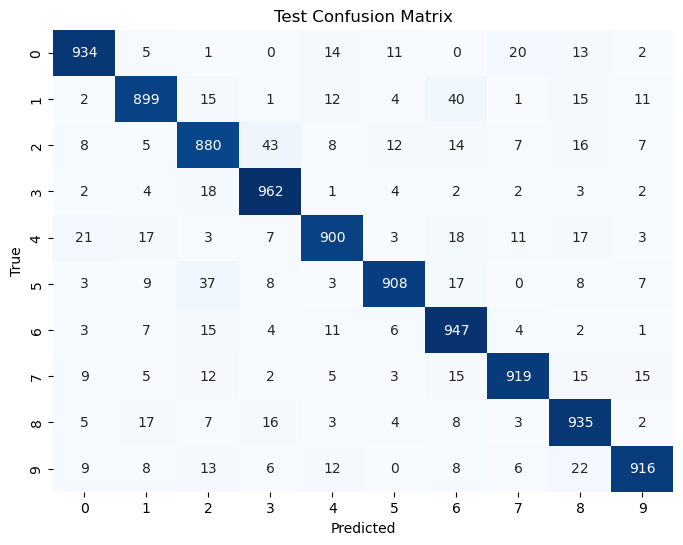

-----------------Accuracy scores for Experiment5-Regularising-0.00005lr - Increase in nodes are: -----------------

Training Accuracy: 0.9996
Testing Accuracy: 0.92


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\1720967736.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [16]:
# Train the model with the best epoch

#4) 2 hidden layers and a dropout - ReLu - Adam - 0.00005 lr

# Define the Neural Network architecture
class NeuralNetwork3(nn.Module):
    def __init__(self):
        super(NeuralNetwork3, self).__init__()  # ⚠️ change name here as well ⚠️
        self.fc1 = nn.Linear(784, 1024)  # hidden layer 1
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.fc2 = nn.Linear(1024, 256)   # hidden layer 2
        self.dropout2 = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.fc3 = nn.Linear(256, 10)    # Output layer with 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.dropout1(x)  # Apply dropout to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.dropout2(x)  # Apply dropout to the second layer
        x = self.fc3(x)  # Output layer
        return x

# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork3()
model.name = "Experiment5-Regularising-0.00005lr - Increase in nodes"
epochs = 100
learning_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Fourth NN architecture, sixth experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
6) Linear, Normalisation, Dropout x 3 - ReLu - Adam - 0.0005 lr
<br> 
<br>


Epoch [1/100], Train Loss: 2.1847670889915305, Test Loss: 2.1293878734111784
Epoch [2/100], Train Loss: 2.0210584594848306, Test Loss: 2.0245024263858795
Epoch [3/100], Train Loss: 1.9182396523495937, Test Loss: 1.9400673121213914
Epoch [4/100], Train Loss: 1.8440253683861265, Test Loss: 1.8757021844387054
Epoch [5/100], Train Loss: 1.7885871385006193, Test Loss: 1.8235522240400315
Epoch [6/100], Train Loss: 1.746626169123548, Test Loss: 1.7871998578310013
Epoch [7/100], Train Loss: 1.7148909944169064, Test Loss: 1.7545311540365218
Epoch [8/100], Train Loss: 1.6886313920325422, Test Loss: 1.731259149312973
Epoch [9/100], Train Loss: 1.6689335934659268, Test Loss: 1.7117444843053817
Epoch [10/100], Train Loss: 1.649940800666809, Test Loss: 1.6917280018329621
Epoch [11/100], Train Loss: 1.6366240719531444, Test Loss: 1.6786083042621613
Epoch [12/100], Train Loss: 1.6242028276971046, Test Loss: 1.6650742024183274
Epoch [13/100], Train Loss: 1.61422755971868, Test Loss: 1.6535232275724412


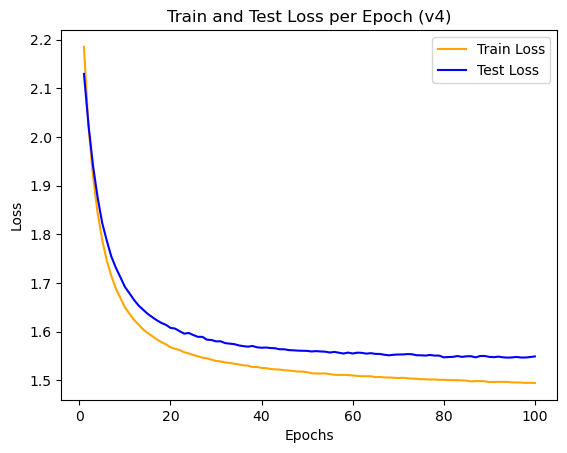

-----------------Experiment6 MODEL-----------------

NeuralNetwork4(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (sigmoid): Sigmoid()
) 

-----------------MODEL EVALUATION-----------------



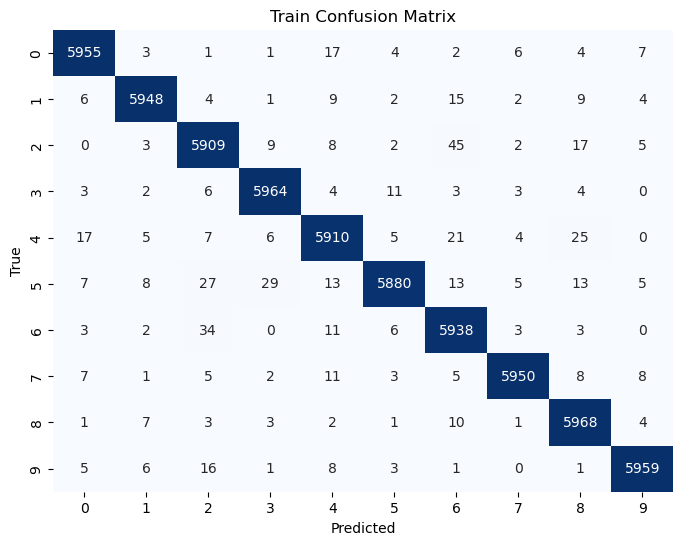

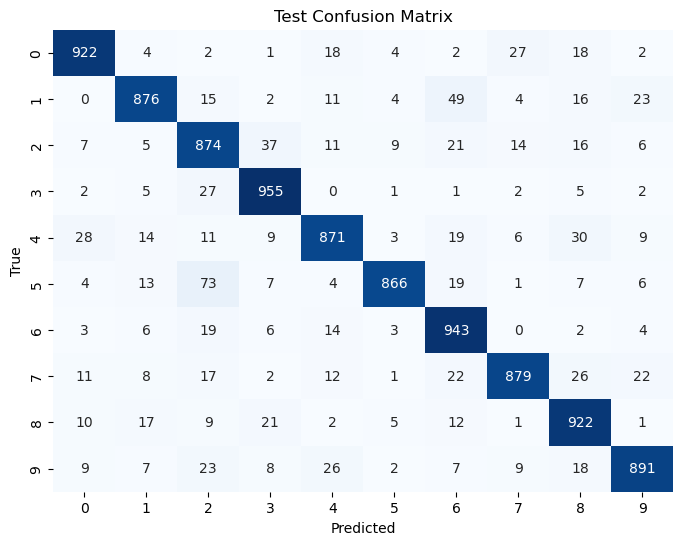

-----------------Accuracy scores for Experiment6 are: -----------------

Training Accuracy: 0.9896833333333334
Testing Accuracy: 0.8999


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\1253273130.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [17]:

# 4th experiment architecture
class NeuralNetwork4(nn.Module):
    def __init__(self):
        super(NeuralNetwork4, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = torch.relu(x)  # Apply ReLU activation function
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = torch.relu(x)  # Apply ReLU activation function
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = torch.relu(x)  # Apply ReLU activation function
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)  # Apply sigmoid activation function for binary classification
        return x
    
# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork4()
model.name = "Experiment6"
epochs = 100
learning_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Fourth NN architecture, seventh experiment
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
8) Linear, Normalisation, Dropout x 3 - SIGMOID - Adam - 0.00005 lr
<br> 
<br>


Epoch [1/100], Train Loss: 2.274633390345472, Test Loss: 2.243855279684067
Epoch [2/100], Train Loss: 2.2180695351133957, Test Loss: 2.199620360136032
Epoch [3/100], Train Loss: 2.1742475306734126, Test Loss: 2.1657997131347657
Epoch [4/100], Train Loss: 2.138654155934111, Test Loss: 2.1388283550739287
Epoch [5/100], Train Loss: 2.108255372148879, Test Loss: 2.1157844841480253
Epoch [6/100], Train Loss: 2.08229581751722, Test Loss: 2.0958606719970705
Epoch [7/100], Train Loss: 2.0595404584357078, Test Loss: 2.0774674832820894
Epoch [8/100], Train Loss: 2.0389125681938007, Test Loss: 2.059567612409592
Epoch [9/100], Train Loss: 2.0205095184610244, Test Loss: 2.043620204925537
Epoch [10/100], Train Loss: 2.0044997123961754, Test Loss: 2.0323157727718355
Epoch [11/100], Train Loss: 1.988326342055138, Test Loss: 2.019182080030441
Epoch [12/100], Train Loss: 1.9750261920563719, Test Loss: 2.0058471113443375
Epoch [13/100], Train Loss: 1.9612469820266074, Test Loss: 1.9936933040618896
Epoch 

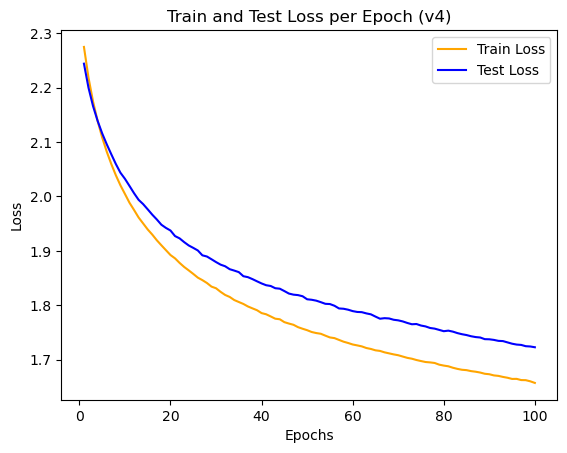

-----------------Experiment5 MODEL-----------------

NeuralNetwork5(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (sigmoid): Sigmoid()
) 

-----------------MODEL EVALUATION-----------------



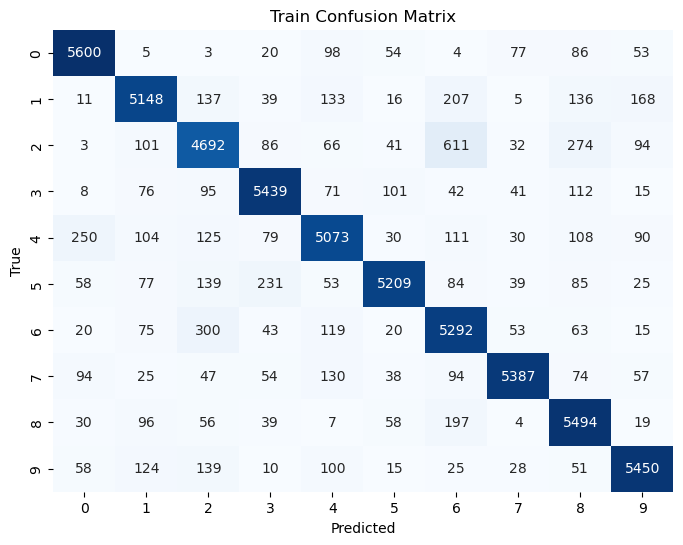

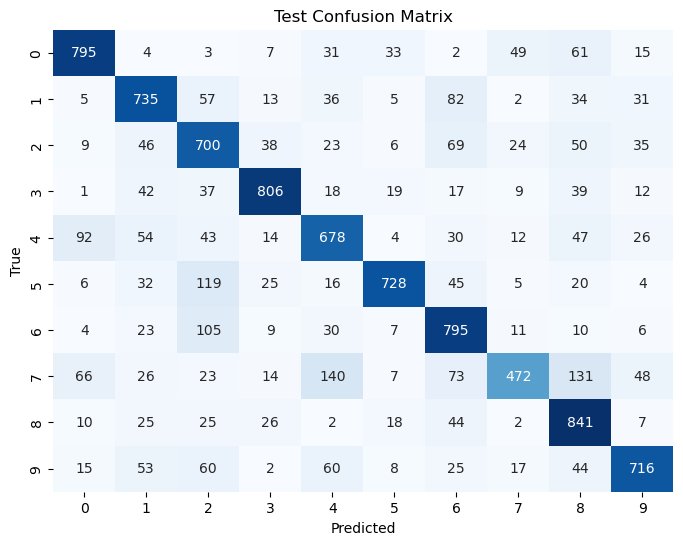

-----------------Accuracy scores for Experiment5 are: -----------------

Training Accuracy: 0.8797333333333334
Testing Accuracy: 0.7266


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\1782427155.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [18]:

# 5th experiment architecture
class NeuralNetwork5(nn.Module):
    def __init__(self):
        super(NeuralNetwork5, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.sigmoid(x)  # Apply sigmoid activation function
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.sigmoid(x)  # Apply sigmoid activation function
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation function
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)  # Apply sigmoid activation function for binary classification
        return x

    
# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork5()
model.name = "Experiment5"
epochs = 100
learning_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## 5th NN, Eight experiments
<br>

<div style="background-color:  #798F9B; padding: 10px; color: white; text-align: left;">
6) Linear, Batch, Dropout **x 5**, more dropout rate
<br> 
<br>


Epoch [1/100], Train Loss: 2.081238196758514, Test Loss: 1.9245392233133316
Epoch [2/100], Train Loss: 1.8208372420453012, Test Loss: 1.7526864737272263
Epoch [3/100], Train Loss: 1.710903154028223, Test Loss: 1.6776160299777985
Epoch [4/100], Train Loss: 1.6541582340889789, Test Loss: 1.6247725933790207
Epoch [5/100], Train Loss: 1.619091570123713, Test Loss: 1.5963511556386947
Epoch [6/100], Train Loss: 1.5959019600076878, Test Loss: 1.59026058614254
Epoch [7/100], Train Loss: 1.5788411399151416, Test Loss: 1.5775584876537323
Epoch [8/100], Train Loss: 1.566830559994312, Test Loss: 1.5726466745138168
Epoch [9/100], Train Loss: 1.557431043969824, Test Loss: 1.5772667497396469
Epoch [10/100], Train Loss: 1.550464752379884, Test Loss: 1.5743311554193498
Epoch [11/100], Train Loss: 1.5438084866138215, Test Loss: 1.5740951418876648
Epoch [12/100], Train Loss: 1.5390126436314684, Test Loss: 1.566623616218567
Epoch [13/100], Train Loss: 1.5356783116117436, Test Loss: 1.5647631853818893
Epoc

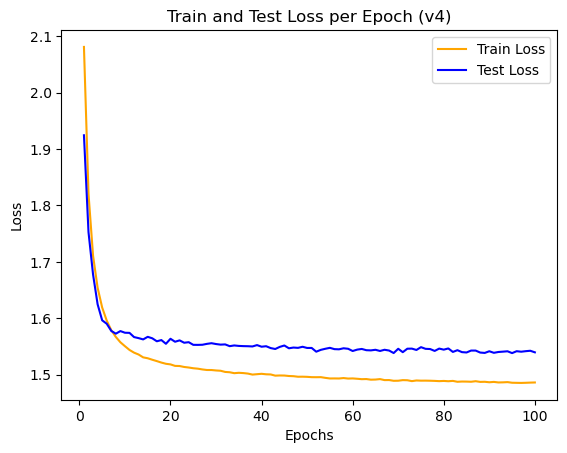

-----------------Experiment8-5 hidden layers. 60% dropout MODEL-----------------

NeuralNetwork5(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (batchnorm5): BatchNorm1d(32, 

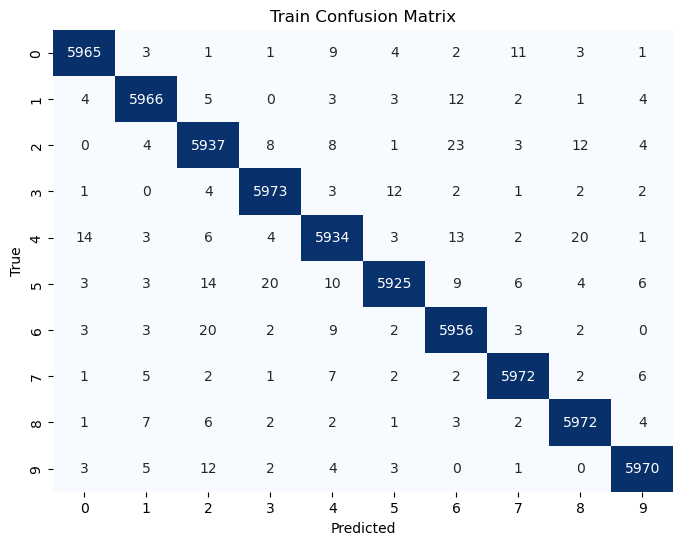

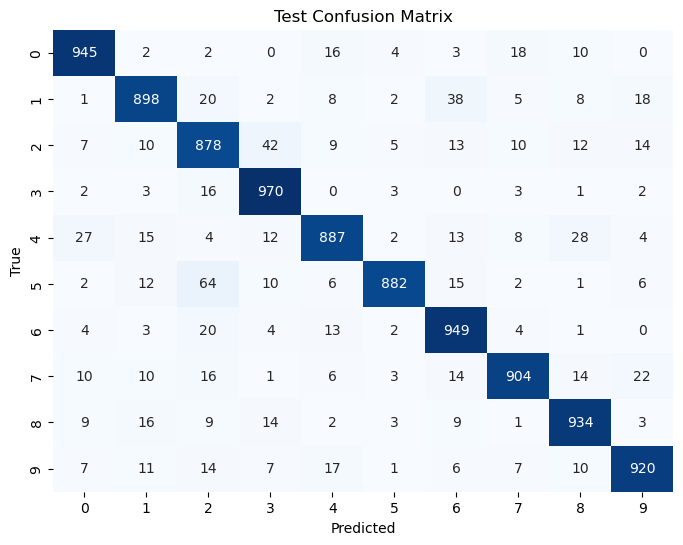

-----------------Accuracy scores for Experiment8-5 hidden layers. 60% dropout are: -----------------

Training Accuracy: 0.9928333333333333
Testing Accuracy: 0.9167


C:\Users\ferra\AppData\Local\Temp\ipykernel_18104\3562188249.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [19]:

# 6th experiment architecture
class NeuralNetwork5(nn.Module):
    def __init__(self):
        super(NeuralNetwork5, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.4)  # Decreased dropout rate
        self.fc2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)  # Decreased dropout rate
        self.fc3 = nn.Linear(256, 128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.4)  # Decreased dropout rate
        self.fc4 = nn.Linear(128, 64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.4)  # Decreased dropout rate
        self.fc5 = nn.Linear(64, 32)
        self.batchnorm5 = nn.BatchNorm1d(32)
        self.dropout5 = nn.Dropout(0.4)  # Decreased dropout rate
        self.fc6 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)  
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)  
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)  
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)  
        x = self.dropout4(x)
        
        x = self.fc5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)  
        x = self.dropout5(x)
        
        x = self.fc6(x)
        x = self.sigmoid(x)  
        return x


    
# ⚠️ Instantiate the model, assign name and Define number of epochs, learning rate, loss function and optimizer  ⚠️
model = NeuralNetwork5()
model.name = "Experiment8-5 hidden layers. 60% dropout"
epochs = 100
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the train_model function
trained_model, total_train_loss, total_test_loss, train_accuracy, test_accuracy, train_preds, train_targets, test_preds, test_targets, device = train_model(model, criterion, optimizer,
                                                                                              train_dataloader, test_dataloader,
                                                                                              epochs=epochs)
print("-----------------{} MODEL-----------------\n".format(model.name))
print(model,"\n")
print("-----------------MODEL EVALUATION-----------------\n")

# Evaluate first experiment
evaluate_model(model, train_dataloader, test_dataloader, device)

# Append results of the current experiment to the dataframe
results_df = results_df.append({
    'Model Name': model.name,
    'Model': model,
    'Total Train Loss': total_train_loss[-1],
    'Total Test Loss': total_test_loss[-1],
    'Train Accuracy': train_accuracy[-1],
    'Test Accuracy': test_accuracy[-1]
}, ignore_index=True)


<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## Summary results
<br>
</div>

Experiment | Architecture                                     | Training Accuracy | Testing Accuracy | Difference (Training - Testing) | Remarks                                
1          | 1 hidden layer (256 nodes), ReLU, ADam, LR:0.005 | 0.9992            | 0.9096           | 0.0896                         | Overfitting, increasing test loss       
2          | 1 hidden layer (256 nodes), ReLU, ADam, LR:0.0005| 1                 | 0.9059           | 0.0941                         | Overfitting, increasing test loss       
3          | 1 hidden layer (256 nodes), ReLU, ADam, LR:0.00005| 0.9825          | 0.8878           | 0.0947                         | Overfitting (sign)                      
4          | 2 hidden layers (256, 64 nodes), Dropout 0.5    | 0.9904            | 0.8902           | 0.1002                         | Still with difference between train and test 
5          | 2 hidden layers (1024, 256 nodes), 2 Dropout 0.5| 0.9995            | 0.9205           | 0.0790                         | Best performance but overfitting        
6          | 3 full connected layers, normalization, ReLU    | 0.9897            | 0.9048           | 0.0849                         | No improvement                          
7          | 3 full connected layers, normalization, Sigmoid | 0.99255           | 0.9069           | 0.08565                        | No improvement                          
8          | 5 pairs of full connected layers, normalization, dropout 0.6 | 0.9928 | 0.9167      | 0.0761                         | Balanced complexity and accuracy       



<div style="text-align: center;">
<div style="background-color: #798F9B; padding: 10px; color: white; text-align: center;">

## End of notebook

<br>

